# Exercises

In [ ]:
import numpy as np
import xarray as xr

In [ ]:
# let's read in rain data
input_file = (
    "PATH_TO_YOUR/RAIN_FILE.nc"
)

# let's load the data by using open_dataset function of xarray
da_pr = (
    xr.open_dataset(
        input_file, chunks={"member_id": 1, "time": 2 * 365, "lon": -1, "lat": -1}
    )
    .rename({"RAIN": "pr"})
    .load()
)["pr"]
da_pr = da_pr * 86400
da_pr.attrs["units"] = "mm/day"  # it is better to modify the attributes as well

# load temp data, roughly for Bern using interpolation, and only look at the past
ds_temp = xr.open_dataset(
    "PATH_TO_YOUR/TEMPERATURE_FILE.nc"
)
temp_bern = (
    ds_temp.sel(time=ds_temp.time.dt.year < 2020)
    .interp(lon=7.4474, lat=46.9480)
    .reset_coords(["lon", "lat"], drop=True)["TREFHT"]
)

Compute the median temperature for each grid point, independently for each member and season

In [18]:
medians = da_pr.groupby("time.season").median(["time", "lat", "lon"])
medians

<xarray.DataArray 'pr' (member_id: 10, season: 4)> Size: 160B
array([[1.9953288e-04, 7.7568786e-03, 1.0463293e-02, 2.1813326e-03],
       [3.9000894e-05, 5.0100684e-03, 6.4141951e-03, 1.6508545e-03],
       [4.0402090e-05, 6.2134946e-03, 7.6570339e-03, 1.3415097e-03],
       [1.4685679e-04, 7.1056839e-03, 1.0767909e-02, 1.7178411e-03],
       [3.6836089e-05, 6.3110166e-03, 9.2160087e-03, 1.7567789e-03],
       [3.8144040e-05, 6.7792316e-03, 8.6833620e-03, 1.8322184e-03],
       [2.9944018e-05, 7.2062286e-03, 8.3437394e-03, 1.3096428e-03],
       [3.9334096e-05, 6.2340358e-03, 7.8184642e-03, 1.7217223e-03],
       [7.4010954e-05, 6.7106038e-03, 7.5125154e-03, 1.9362553e-03],
       [7.9551493e-05, 5.9338417e-03, 9.9677313e-03, 1.9861623e-03]],
      dtype=float32)
Coordinates:
  * member_id  (member_id) <U12 480B 'r10i1231p1f1' ... 'r2i1251p1f1'
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    units:    mm/day

For the gridpoint closest to Bern, compute the monthly climatology of temperatures

In [25]:
monthly_clim_bern = temp_bern.groupby("time.month").mean()

For the gridpoint closest to Bern, compute the monthly mean anomalies of temperatures

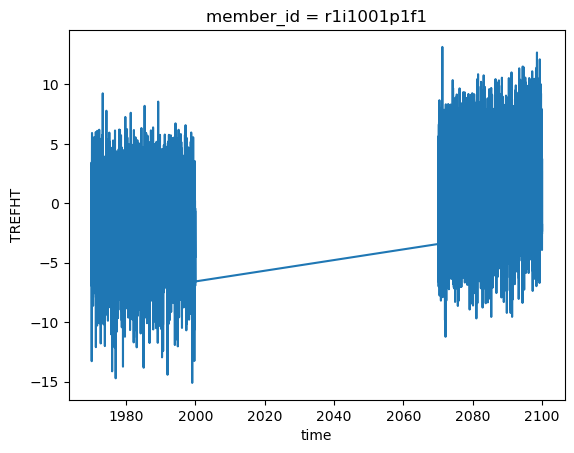

In [28]:
anom_monthly = temp_bern.groupby("time.month") - monthly_clim_bern
anom_monthly[0, :].plot()

A bit harder: For the gridpoint closest to Bern, the first member and only for dates before 2010, print the longest series of consecutive hot months (month whose monthly anomaly is above the 95th percentile of temperature anomalies)

In [71]:
from itertools import groupby


def get_runs(seq: np.ndarray):
    runs = []
    dtype_code = seq.dtype.char
    start = 0
    for key, run in groupby(seq):  # groupby iterates over the seq you give it
        length = sum(1 for _ in run)
        runs.append((key, start, length))
        start = start + length
    runs = np.asarray(runs, dtype=[('values', dtype_code), ('start', 'i4'), ('length', 'i4')])
    # using the nice numpy structued arrays to store our data
    return runs

In [81]:
subset_temp = anom_monthly.isel(member_id=0).sel(time=anom_monthly.time.dt.year < 2010)
subset_temp = subset_temp.resample(time="1ME").mean()
runs = get_runs(subset_temp > subset_temp.quantile(0.95))

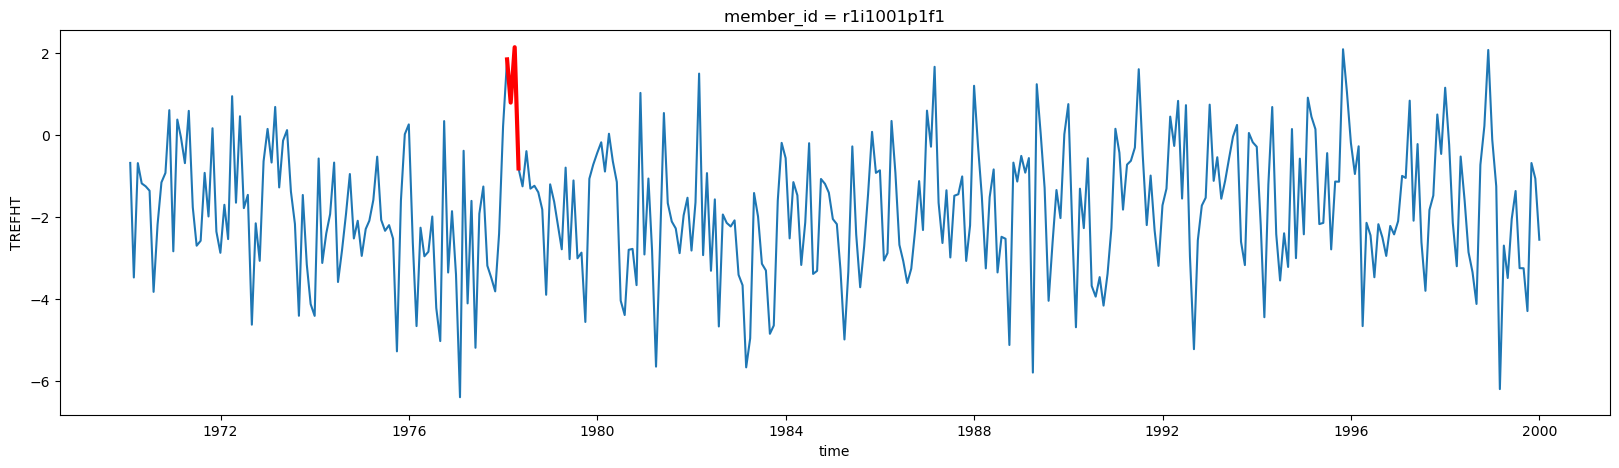

In [85]:
pos_runs = runs[runs["values"]]
longest_run = pos_runs["length"].argmax()
start_longest = pos_runs["start"][longest_run]
end_longest = pos_runs["start"][longest_run] + pos_runs["length"][longest_run]

subset_temp.plot(figsize=(20, 5))
subset_temp[start_longest:(end_longest + 1)].plot(color="red", lw=3)